## Fire data

In [950]:
library(geodata)
counties <- gadm(country='USA',level=2,path=tempdir(),resolution=1)
counties$NAME_2[counties$NAME_1=='New Mexico'&counties$NAME_2=='Debaca'] <- 'De Baca'
states <- gadm(country='USA',level=1,path=tempdir(),resolution=2)

In [88]:
db_all <- vect('~/Downloads/InterAgencyFirePerimeterHistory_All_Years_View/InterAgencyFirePerimeterHistory_All_Years_View.shp')
db_all <- project(db_all,'epsg:4326')
db_usfs <- db_all[db_all$SOURCE=='USFS',]
head(db_usfs,2)

OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,UNIT_ID,POO_RESP_I,FEATURE_CA,GIS_ACRES,USER_NAME,SOURCE,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
73765,Digitized From Hardcopy PBS/SEQ,200111020000,.10 acres,{0E4E1E79-3644-4ED4-A1C5-E9D710F82C5B},NA,NA,2001,041,North Prong,NA,VAVAF,Wildfire Final Perimeter,0.007,NA,USFS,USFS,2001,44.24219,23.78901
73766,Digitized From Hardcopy PBS/SEQ,198911050000,.10 acres,{AC79C98B-8048-4C33-9086-E3A936AE5FDF},NA,NA,1989,023,Bald Mountain Fire,NA,VAVAF,Wildfire Final Perimeter,0.007,NA,USFS,USFS,1989,44.24219,23.80061


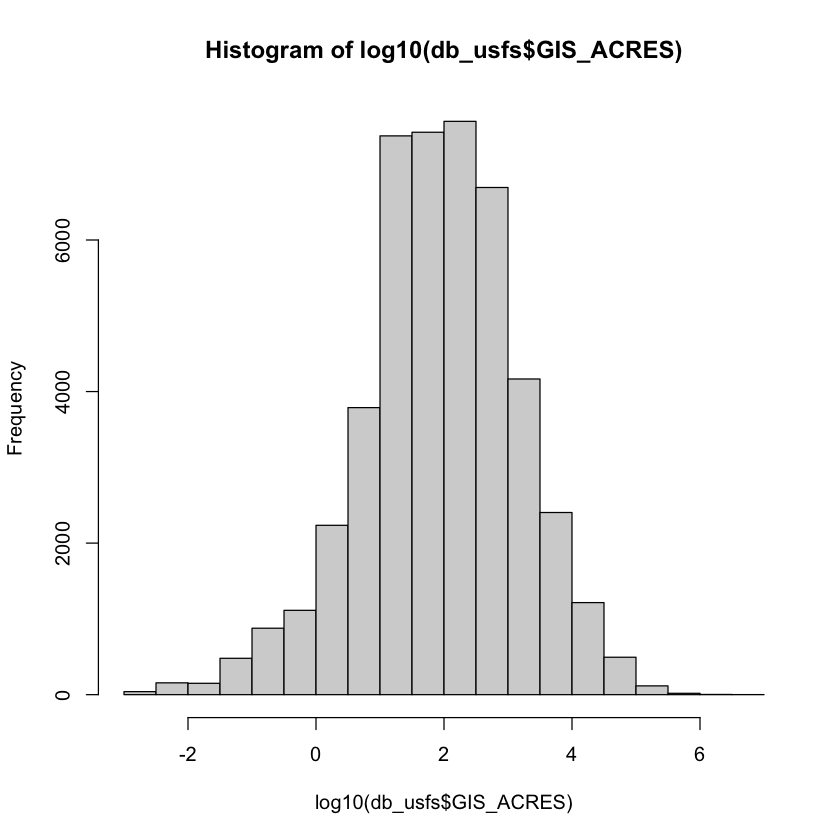

[1] 263  20

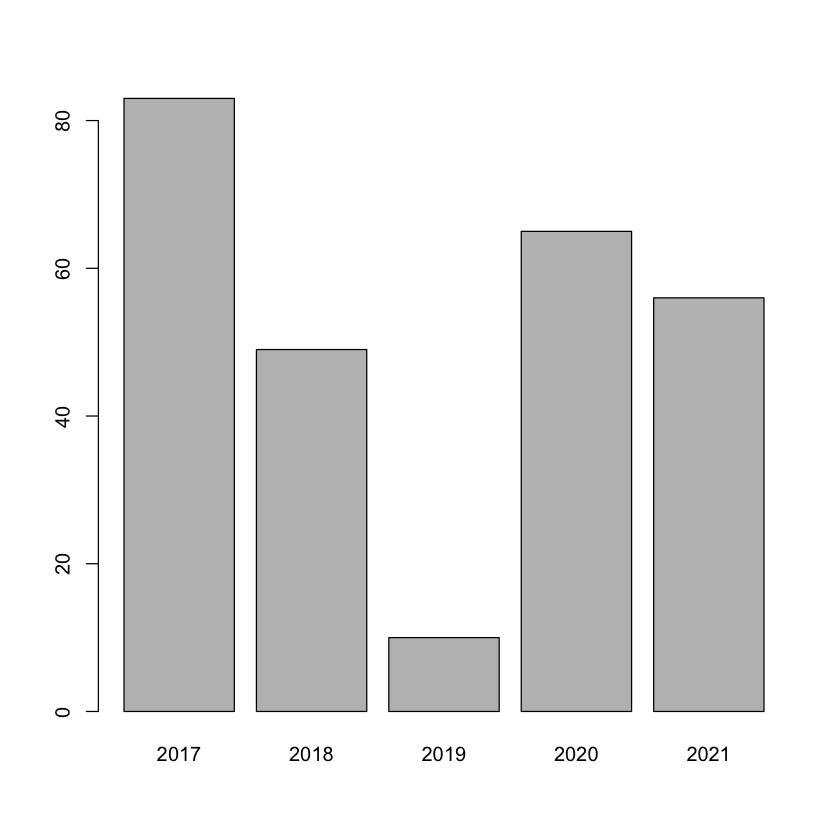

In [106]:
hist(log10(db_usfs$GIS_ACRES))
fires0 <- db_usfs[db_usfs$FIRE_YEAR_>2016&db_usfs$GIS_ACRES>10000,]
barplot(table(fires0$FIRE_YEAR_))
dim(fires0)

## Neighbour counties

In [1109]:
adj_counties <- adjacent(counties)

In [957]:
fires0 <- db_usfs[db_usfs$FIRE_YEAR_>2016&db_usfs$GIS_ACRES>10000,]
y <- relate(counties,fires0,'intersects',pairs=T)
zz <- relate(counties,fires0,'contains',pairs=T)
fires <- fires0[zz[,'id.y'],]

adj_fire_counties <- adj_counties[adj_counties[,'from']%in%zz[,'id.x'],]
fire_from_year <- sapply(adj_fire_counties[,'from'], function(cnt) {
  yrs <- unique(values(fires0[zz[zz[,'id.x']==cnt,'id.y'],'FIRE_YEAR_']))
  return(as.integer(unlist(yrs)))
})
fire_to_year <- sapply(adj_fire_counties[,'to'], function(cnt) {
  yrs <- unique(values(fires0[y[y[,'id.x']%in%cnt,'id.y'],'FIRE_YEAR_']))
  if(nrow(yrs)==0) return(NA)
  else return(as.integer(unlist(yrs)))
})

In [1112]:
fire_counties <- data.frame(from=adj_fire_counties[,'from'],
                            counties[adj_fire_counties[,'from'],c('NAME_1','NAME_2','HASC_2')],
                            to=adj_fire_counties[,'to'],
                            counties[adj_fire_counties[,'to'],c('NAME_1','NAME_2','HASC_2')])
fire_counties$fire_from_year <- fire_from_year
fire_counties$fire_to_year <- fire_to_year
names(fire_counties) <- c('from','cnt1_state','cnt1_county','cnt1_HASC',
                          'to','cnt2_state','cnt2_county','cnt2_HASC',
                          'fire_year1','fire_year2')
dim(fire_counties)

[1] 504  10

In [1130]:
fire_counties$eligible_year <- apply(fire_counties[,c('fire_year1','fire_year2')], 1, function(yrs) sort(setdiff(yrs[[1]],yrs[[2]])))
options(width=170)
options(setWidthOnResize=TRUE)
d_FireCounty <- fire_counties[sapply(fire_counties$eligible_year,length)>0,-c(4,8)]
dim(d_FireCounty)
head(d_FireCounty)

[1] 359   9

,from,cnt1_state,cnt1_county,to,cnt2_state,cnt2_county,fire_year1,fire_year2,eligible_year
,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<list>,<list>,<list>
2,95,Arizona,Cochise,99,Arizona,Greenlee,2017,"2021, 2020, 2018",2017
4,95,Arizona,Cochise,106,Arizona,Santa Cruz,2017,NA,2017
5,95,Arizona,Cochise,1810,New Mexico,Hidalgo,2017,NA,2017
6,96,Arizona,Coconino,97,Arizona,Gila,"2019, 2018, 2017, 2021, 2020","2021, 2019, 2020","2017, 2018"
7,96,Arizona,Coconino,102,Arizona,Mohave,"2019, 2018, 2017, 2021, 2020",NA,"2017, 2018, 2019, 2020, 2021"
8,96,Arizona,Coconino,103,Arizona,Navajo,"2019, 2018, 2017, 2021, 2020",NA,"2017, 2018, 2019, 2020, 2021"


In [1131]:
cnt1 <- unique(d_FireCounty[,c('cnt1_state','cnt1_county')])
cnt2 <- unique(d_FireCounty[,c('cnt2_state','cnt2_county')])
dim(cnt1)
dim(cnt2)
cnts <- unique(data.table::rbindlist(list(cnt1,cnt2),use.names = F))
dim(cnts)

[1] 79  2

[1] 211   2

[1] 243   2

In [1278]:
cnt_ind <- c(2,4, 10, 17, 19,20,21, 32,36, 44, 49,50,51, 55,56,58, 62,65,67, 69,71,
             73,74,76, 77, 84, 86, 91,96, 100,101, 105, 112, 114,120, 122, 126, 129,
             133,134,136,138,139, 141,142, 152, 159, 165, 168,169,172, 181, 182,183,
             193,197,198,199, 204,205, 207,208, 216,217,218,219, 222, 235, 242, 248, 253,
             257, 271, 273, 279,280, 283, 287, 298, 305, 313, 319, 327, 331, 340, 344, 351,
             356, 364, 367,368,369,370, 379, 381, 394, 401, 408, 415, 426, 427, 434, 442,
             446, 451, 456, 466, 471, 481, 486, 493, 503)
cnt_ind <- c(4, 10, 17, 19, 25, 32, 40, 44, 48, 55, 62, 69,
             76, 77, 84, 86, 95, 100, 105, 112, 120, 122, 126, 129,
             138, 141, 152, 159, 162,165, 169, 181, 182,
             193, 204, 208, 219, 222, 235, 242, 248, 253,
             257, 271, 273, 279, 283, 287, 298, 305, 313, 319, 322, 331, 340, 344, 351,
             356, 364, 369, 379, 381, 394, 401, 409, 415, 426, 427, 434, 442,
             446, 451, 456, 468, 471, 481, 486, 493, 503)
cnt_ind <- as.character(cnt_ind)
dd_FireCounty <- d_FireCounty[cnt_ind,]

## GDP data

* All industry total (7)
  - Private industries (8)
    * Agriculture, forestry, fishing and hunting (9)
    * Mining, quarrying, and oil and gas extraction (10)
    * Utilities (11)
    * Construction (12)
    * Manufacturing (13)
      * Durable goods manufacturing
      * Nondurable goods manufacturing
    * Wholesale trade (16)
    * Retail trade (17)
    * Transportation and warehousing (18)
    * Information (19)
    * Finance, insurance, real estate, rental, and leasing (20)
      * Finance and insurance
      * Real estate and rental and leasing
    * Professional and business services (23)
      * Professional, scientific, and technical services
      * Management of companies and enterprises
      * Administrative and support and waste management and remediation services
    * Educational services, health care, and social assistance (27)
      * Educational services
      * Health care and social assistance
    * Arts, entertainment, recreation, accommodation, and food services (30)
      * Arts, entertainment, and recreation
      * Accommodation and food services
    * Other services (except government and government enterprises) (33)
  - Government and government enterprises (34)

In [1311]:
library(readxl)
xlsx1 <- excel_sheets('~/Downloads/temp_figs/GDP_DATA.xlsx')[-(1:2)]
xlsx2 <- excel_sheets('~/Downloads/temp_figs/sup_GDP_DATA.xlsx')[-(1:2)]
ln_sect <- list(all=7, prv=8, agr=9, min=10,utl=11,con=12,mnf=13,whl=16,rtl=17,
                trs=18,inf=19,fin=20,prf=23,edu=27,art=30,oth=33,gov=34)

sect <- 'art'
ln <- ln_sect[[sect]]
gdps1 <- sapply(xlsx1, function(cnt) {
  gdp <- read_xlsx('~/Downloads/temp_figs/GDP_DATA.xlsx',cnt,range=sprintf('E%d:J%d',ln,ln),
                   col_names=as.character(2017:2022),na='(D)')
  gdp[gdp=='(D)'] <- NA
  gdp <- as.numeric(gdp)
  return(gdp)
})
gdps2 <- sapply(xlsx2, function(cnt) {
  gdp <- read_xlsx('~/Downloads/temp_figs/sup_GDP_DATA.xlsx',cnt,range=sprintf('E%d:J%d',ln,ln),
                   col_names=as.character(2017:2022),na='(D)')
  gdp[gdp=='(D)'] <- NA
  gdp <- as.numeric(gdp)
  return(gdp)
})

gdps <- cbind(gdps1,gdps2)
rownames(gdps) <- as.character(2017:2022)
dim(gdps)
nm_cnt <- strsplit(colnames(gdps),', ')
colnames(gdps) <- sapply(nm_cnt, function(x) paste(state.name[state.abb==x[2]],x[1],sep=', '))
gdps <- gdps[,sort(colnames(gdps))]

[1]   6 257

In [1312]:
gdp_rel_rate <- apply(gdps,2,function(x) (x[-1]-x[-length(x)]+1)/(x[-length(x)]+1)*100)  ## +1 is to avoid Inf
head(gdp_rel_rate)

,"Arizona, Apache","Arizona, Cochise","Arizona, Coconino","Arizona, Gila","Arizona, Graham","Arizona, Greenlee","Arizona, La Paz","Arizona, Maricopa","Arizona, Mohave","Arizona, Navajo",⋯,"Wyoming, Big Horn","Wyoming, Carbon","Wyoming, Converse","Wyoming, Fremont","Wyoming, Hot Springs","Wyoming, Laramie","Wyoming, Park","Wyoming, Platte","Wyoming, Teton","Wyoming, Washakie"
2018,NA,-1.780271,3.994438,3.024569,NA,NA,9.321888,3.721827,-1.282678,2.0609558,⋯,NA,-6.4315741,-8.2259607,NA,-15.383031,-3.578633,-3.1058253,1.079213,-2.240186,1.102464
2019,-2.655776,-4.282023,-2.643258,-2.185981,2.457809,NA,-10.461021,-3.065132,-7.927635,0.9647939,⋯,NA,3.9853029,16.0453709,NA,-6.011926,NA,0.6124151,3.559216,-1.249233,-3.517588
2020,-20.655149,-14.300781,-24.367470,-12.930596,-3.924531,-28.84362,-11.009496,-21.475433,-14.084292,-14.5297350,⋯,NA,-6.5247433,0.6921695,NA,8.313908,NA,-13.3782874,-7.527969,-9.660989,-2.504710
2021,43.941408,38.239427,35.776292,28.878583,18.196464,NA,93.442392,18.831567,NA,23.3256067,⋯,NA,18.8356164,5.9823678,NA,24.476862,NA,23.0727827,NA,39.835623,13.790359
2022,4.051001,5.054444,2.302736,5.534656,-1.301357,NA,-2.656400,12.632189,NA,4.6351766,⋯,-3.337906,0.8125984,-3.9069077,NA,1.690844,NA,-0.1247236,NA,10.394808,-4.566347


## Integrate fire and GDP data

In [1313]:
d_FireGDP <- apply(dd_FireCounty,1,function(x) {
  cnt12 <- c(paste(x$cnt1_state, x$cnt1_county, sep=', '), paste(x$cnt2_state, x$cnt2_county, sep=', '))
  yrs <- intersect(x$eligible_year,rownames(gdp_rel_rate))
  if(length(yrs)>0) gdp_rel_rate[as.character(yrs), cnt12, drop=F]
  else NULL
})
d1_FireGDP <- data.frame()
for(i in seq_along(d_FireGDP)) {
  if(is.null(d_FireGDP[[i]])) next
  d <- d_FireGDP[[i]]
  colnames(d) <- c('perc_cnt1','perc_cnt2')
  d1_FireGDP <- rbind(d1_FireGDP,data.frame(ind=names(d_FireGDP)[i],d,
                                            cnt1=colnames(d_FireGDP[[i]])[1],cnt2=colnames(d_FireGDP[[i]])[2],
                                            yr=rownames(d_FireGDP[[i]])))
}
rownames(d1_FireGDP) <- NULL
head(d1_FireGDP)

,ind,perc_cnt1,perc_cnt2,cnt1,cnt2,yr
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,10,3.994438,12.557250,"Arizona, Coconino","Utah, Kane",2018
2,10,-2.643258,7.449233,"Arizona, Coconino","Utah, Kane",2019
3,10,-24.367470,-15.660990,"Arizona, Coconino","Utah, Kane",2020
4,10,35.776292,31.351067,"Arizona, Coconino","Utah, Kane",2021
5,17,-12.930596,-14.770920,"Arizona, Gila","Arizona, Yavapai",2020
6,19,18.196464,38.239427,"Arizona, Graham","Arizona, Cochise",2021



	Paired t-test

data:  d1_FireGDP[, "perc_cnt1"] and d1_FireGDP[, "perc_cnt2"]
t = 0.7731, df = 62, p-value = 0.7788
alternative hypothesis: true mean difference is less than 0
95 percent confidence interval:
     -Inf 2.957447
sample estimates:
mean difference 
      0.9359365 


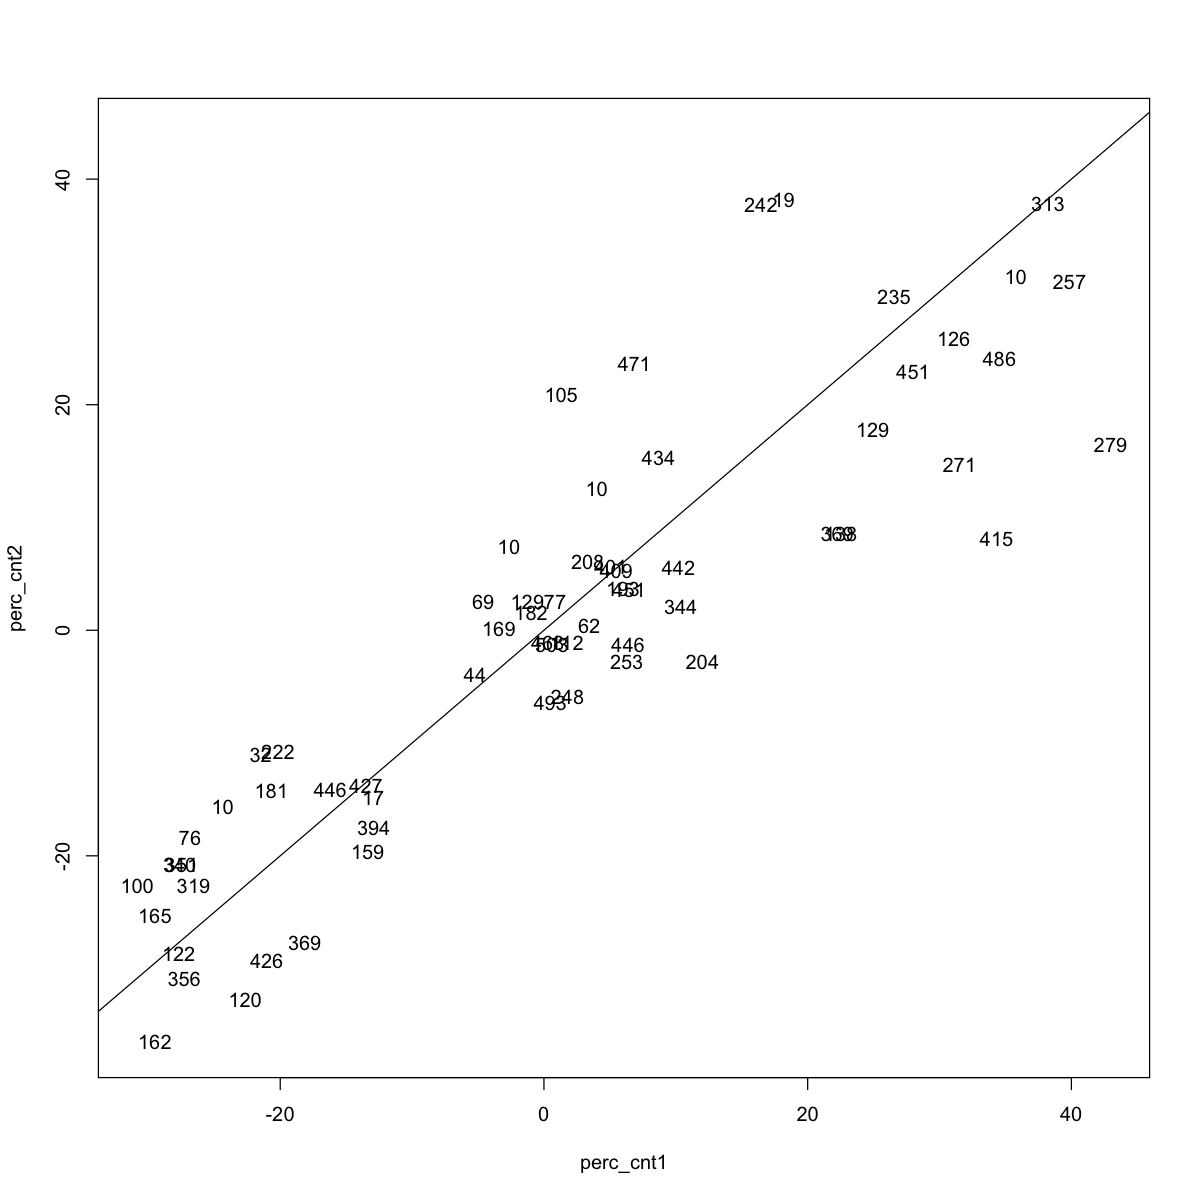

In [1314]:
plot(d1_FireGDP[,2:3],type='n')
text(d1_FireGDP[,2:3],d1_FireGDP[,1])
abline(0,1)
t.test(d1_FireGDP[,'perc_cnt1'],d1_FireGDP[,'perc_cnt2'],paired=T,alternative=')

In [1316]:
?t.test

t.test {stats},R Documentation
x,a (non-empty) numeric vector of data values.
y,an optional (non-empty) numeric vector of data values.
alternative,"a character string specifying the alternative hypothesis, must be one of ""two.sided"" (default), ""greater"" or ""less"". You can specify just the initial letter."
mu,a number indicating the true value of the mean (or difference in means if you are performing a two sample test).
paired,a logical indicating whether you want a paired t-test.
var.equal,a logical variable indicating whether to treat the two variances as being equal. If TRUE then the pooled variance is used to estimate the variance otherwise the Welch (or Satterthwaite) approximation to the degrees of freedom is used.
conf.level,confidence level of the interval.
formula,"a formula of the form lhs ~ rhs where lhs is a numeric variable giving the data values and rhs either 1 for a one-sample or paired test or a factor with two levels giving the corresponding groups. If lhs is of class ""Pair"" and rhs is 1, a paired test is done"
data,an optional matrix or data frame (or similar: see model.frame) containing the variables in the formula formula. By default the variables are taken from environment(formula).
subset,an optional vector specifying a subset of observations to be used.


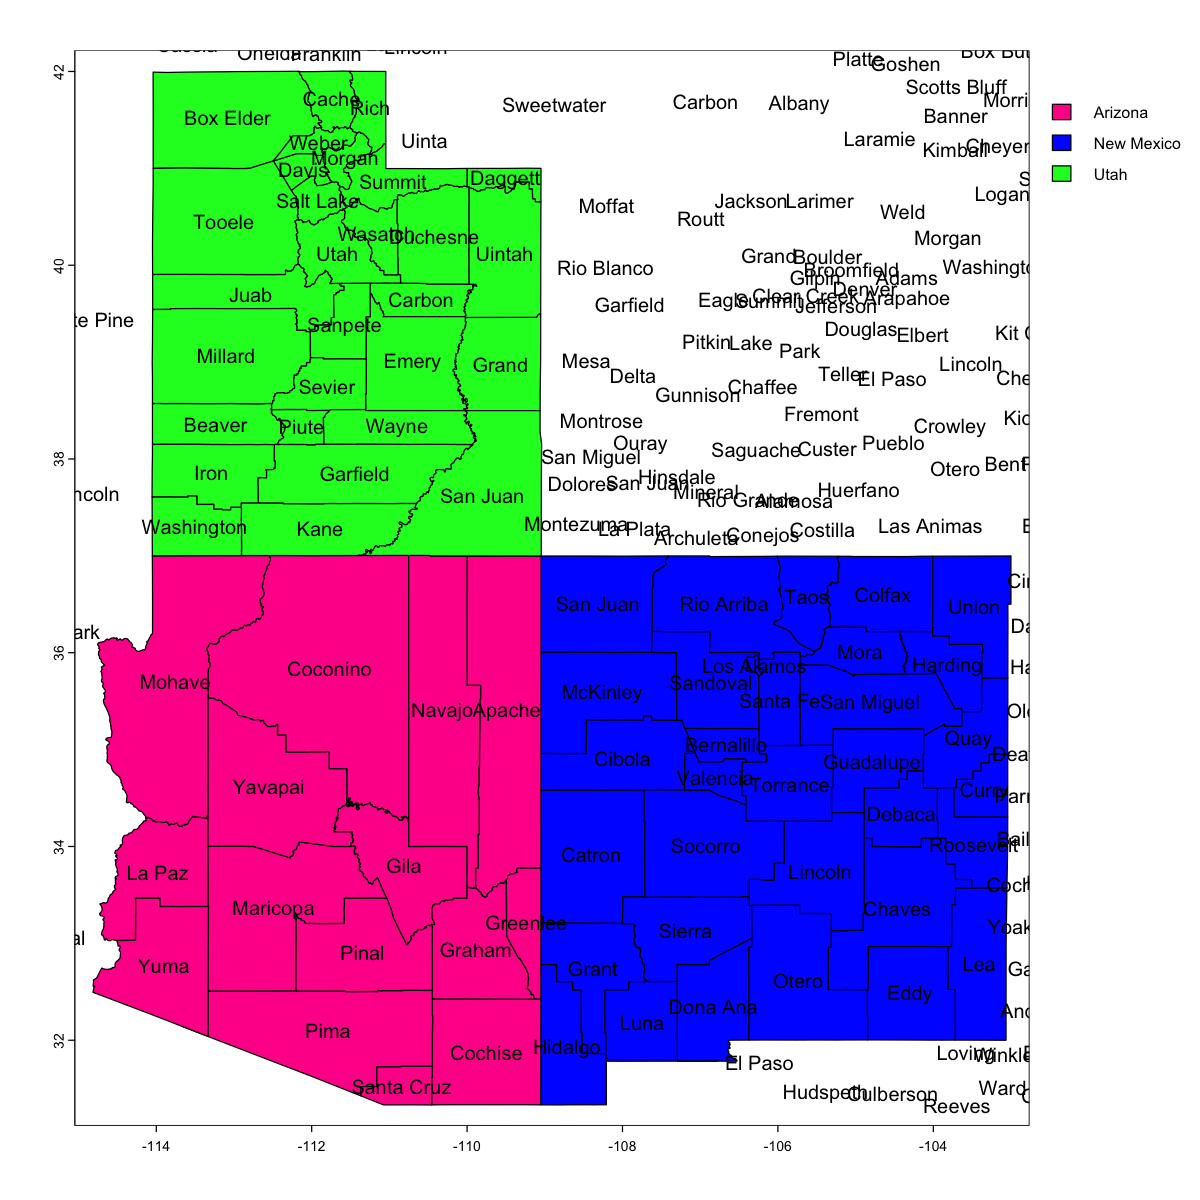

In [1026]:
options(repr.plot.width=10, repr.plot.height=10)
plot(counties[counties$NAME_1%in%c('Arizona','Utah','New Mexico'),],'NAME_1')
text(counties,'NAME_2')

In [1153]:
head(d1_FireGDP)

,perc_cnt1,perc_cnt2,cnt1,cnt2,yr
,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,0.6770935,-3.303304,"Arizona, Coconino","Arizona, Gila",2018
2,0.6770935,2.844464,"Arizona, Coconino","Arizona, Mohave",2018
3,-2.5550042,3.530639,"Arizona, Coconino","Arizona, Mohave",2019
4,-9.8798186,3.342335,"Arizona, Coconino","Arizona, Mohave",2020
5,9.2184289,9.074822,"Arizona, Coconino","Arizona, Mohave",2021
6,0.6770935,5.925394,"Arizona, Coconino","Arizona, Navajo",2018


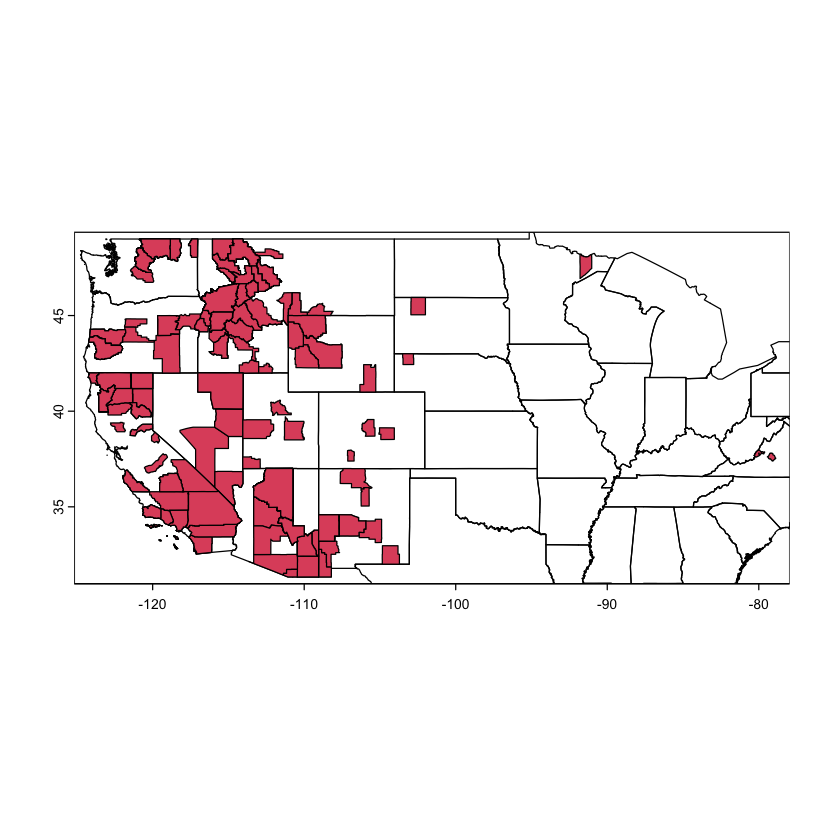

In [ ]:
plot(states,ext=ext(unique(cnties)))
plot(cnties,add=T,col=2)

In [67]:
unq_cnties <- unique(data.frame(cnties))
unq_cnties[order(unq_cnties$NAME_1),]

,NAME_1,NAME_2
,<chr>,<chr>
5,Arizona,Coconino
8,Arizona,Cochise
10,Arizona,Yavapai
94,Arizona,Graham
140,Arizona,Gila
142,Arizona,Pima
171,Arizona,Santa Cruz
207,Arizona,Maricopa
240,Arizona,Greenlee


In [20]:
library(relaimpo)
x1 <- rnorm(300)
x2 <- x1*2+4+rnorm(300,0,0.1)
z <- data.frame(y=3*x1+2*x2+rnorm(300,0,0.2),x1,x2)
calc.relimp(lm(y~x1+x2,z))

Response variable: y 
Total response variance: 58.02278 
Analysis based on 300 observations 

2 Regressors: 
x1 x2 
Proportion of variance explained by model: 99.94%
Metrics are not normalized (rela=FALSE). 

Relative importance metrics: 

         lmg
x1 0.4994594
x2 0.4998975

Average coefficients for different model sizes: 

         1X      2Xs
x1 7.008428 2.715022
x2 3.504380 2.148421

In [25]:
library('circular')
n <- 50
x <- rvonmises(n, mu=circular(0), kappa=3)
y <- x + rvonmises(n, mu=circular(pi), kappa=10)



Attaching package: ‘circular’


The following objects are masked from ‘package:stats’:

    sd, var




In [42]:
x %% (2*pi)

Circular Data: 
Type = angles 
Units = radians 
Template = none 
Modulo = asis 
Zero = 0 
Rotation = counter 
 [1] 0.22947275 0.34424307 5.81987175 5.41649765 5.85417246 0.27216487
 [7] 5.55850833 5.82130201 6.12534296 0.18498628 0.05858188 0.72975909
[13] 0.75287197 0.85841522 0.10854062 6.23129000 6.10194758 0.27235887
[19] 0.53670911 0.84660835 0.61757522 1.06431235 0.64561171 0.89585745
[25] 6.19112080 0.75752589 6.07271234 6.19420797 6.05291611 0.02548236
[31] 5.20192880 0.29788367 0.02206176 0.03469150 0.39099719 5.03307442
[37] 6.13405048 5.64810681 5.97339274 5.73377489 5.46539097 0.46566801
[43] 0.36898583 0.40421774 0.57275855 5.59972133 5.29997437 0.06464476
[49] 6.08581317 5.72117442

In [788]:
history()

ERROR: Error in .External2(C_savehistory, file): no history available to save


In [789]:
save.image(file='Untitled.Rda')